# Decision Trees
We will now build a Decision Tree Classifier with depth of 3 - first without decreasing dimensions, then with applying PCA first

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the extracted high-level features
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-train-features.npz") as npz_file:
    hl_tr_features = npz_file["features"]
    tr_labels = npz_file["labels"]
    
print("train features shape:", hl_tr_features.shape)
print("train labels shape:", tr_labels.shape)

train features shape: (280, 1280)
train labels shape: (280,)


In [3]:
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-valid-features.npz") as npz_file:
    hl_val_features = npz_file["features"]
    val_labels = npz_file["labels"]
    
print("validation features shape:", hl_val_features.shape)
print("validation labels shape:", val_labels.shape)

validation features shape: (139, 1280)
validation labels shape: (139,)


In [4]:
with np.load("/Users/Ingo/Python Files/Course-project4/high-level-test-features.npz") as npz_file:
    hl_te_features = npz_file["features"]
    te_labels = npz_file["labels"]
    
print("test features shape:", hl_te_features.shape)
print("test labels shape:", te_labels.shape)

test features shape: (50, 1280)
test labels shape: (50,)


Now build a Decision Tree Classifier with depth = 3.

Our decision tree will learn the rules itself on which it decides to split data at the nodes. The goal is to classify the given high-level features in `hl_tr_features` around the 6 classes: bike, car, motorcycle, other, truck, and van.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz # to visualize the decision tree

# create object
dt = DecisionTreeClassifier(criterion = "gini", # use gini impurity measure
                           max_depth = 3, # depth of 3
                           random_state = 0)

# fit object
# our data is already split and the labels are already one-hot-encoded
dt.fit(hl_tr_features, tr_labels)

# get accuracy based off validation data
dt_accuracy = dt.score(hl_val_features, val_labels)
print("Decision Tree (depth = 3) validation set accuracy = {:.3f}".format(dt_accuracy))

# for comparison: training accuracy
print("Decision Tree (depth = 3) training accuracy = {:.3f}".format(dt.score(hl_tr_features, tr_labels)))

Decision Tree (depth = 3) validation set accuracy = 0.676
Decision Tree (depth = 3) training accuracy = 0.775


Based on this approach with depth = 3, the model already seems to overfit with an accuracy difference of around 10 percentage points. Furthermore, the accuracy is far lower than in the k-NN model.

Just thinking about it now, it would make sense to me that a model which is trying to define rules for 1280 possible features reaches worse results with a depth of only 3. Especially discriminating among features marking the difference between trucks, busses, generally big cars, seems very difficult to do with high accuracy.

The following plot will describe the chosen rules

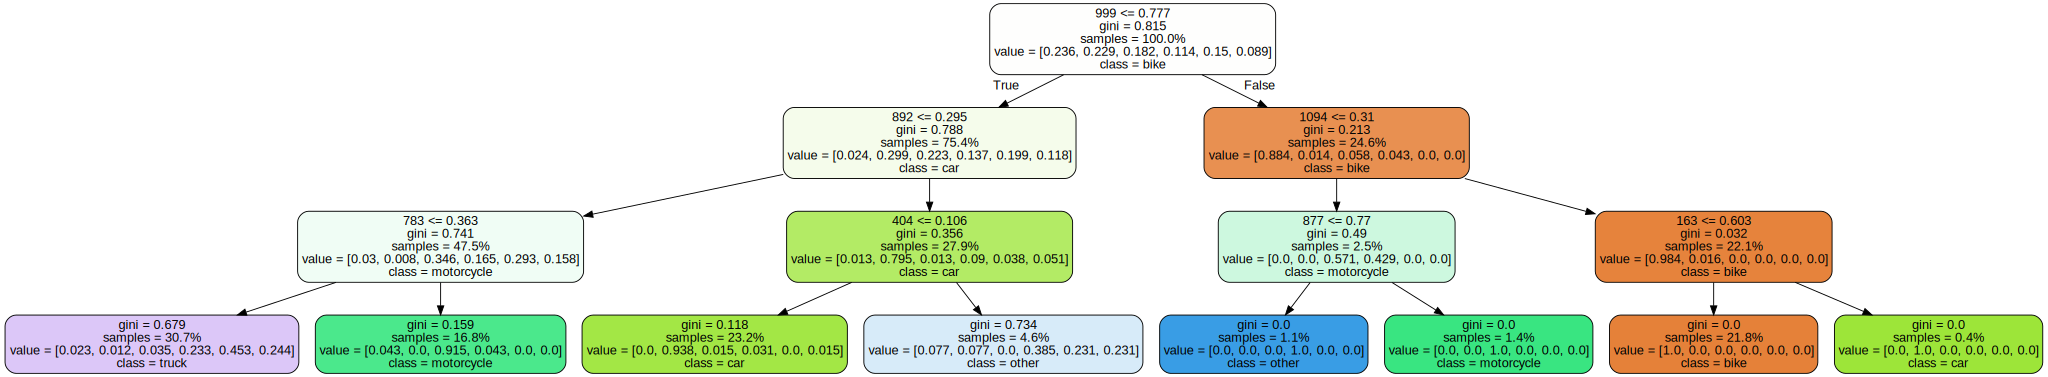

In [6]:
# export decision tree
dot_data = export_graphviz(dt, # tree to export
                          out_file = None, # do not create file
                          class_names = ["bike", "car", "motorcycle", "other", "truck", "van"],
                          feature_names = np.arange(1280), # feature names = numbers of columns from 0 to 1280
                          filled = True, rounded = True,
                          proportion = True # include proportion of each class in graph
                          )
import graphviz
graphviz.Source(dot_data)

In this case, the Decision Tree algorithm found that the most important feature to split at is number 999. After that, we split at features 892 and 1094. We have seen feature 1094 already in the PCA (`n_components = 2`) plot as the second most important feature. 

Maybe if we apply PCA first, we can improve our results. In this case, I will set `n_components = 7` as we have a depth of `n = 3` in our decision tree 

In [7]:
from sklearn.decomposition import PCA

# create object
dt_pca_transformer = PCA(n_components = 7, # 7 components to depth of n = 3 decision tree
            random_state = 0)

# fit object, transform same training features
dt_pca_tr = dt_pca_transformer.fit_transform(hl_tr_features)

# also transform validation and test data on same fit
dt_pca_val = dt_pca_transformer.transform(hl_val_features)
dt_pca_te = dt_pca_transformer.transform(hl_te_features)

# print shape
print("training input shape after PCA:", dt_pca_tr.shape)
print("validation input shape after PCA:", dt_pca_val.shape)
print("test input shape after PCA:", dt_pca_te.shape)

# show the 7 features
dt_pca_df = pd.DataFrame({
    "variance": hl_tr_features.var(axis = 0),
    "component 1": dt_pca_transformer.components_[0],
    "component 2": dt_pca_transformer.components_[1],
    "component 3": dt_pca_transformer.components_[2],
    "component 4": dt_pca_transformer.components_[3],
    "component 5": dt_pca_transformer.components_[4],
    "component 6": dt_pca_transformer.components_[5],
    "component 7": dt_pca_transformer.components_[6]
})

dt_pca_df.sort_values(by = "variance", ascending = False)[:10]

training input shape after PCA: (280, 7)
validation input shape after PCA: (139, 7)
test input shape after PCA: (50, 7)


,variance,component 1,component 2,component 3,component 4,component 5,component 6,component 7
54,1.008391,0.122005,-0.097957,-0.015874,0.009551,-0.081923,0.031803,0.026584
1094,0.898203,0.092074,-0.098863,0.087285,0.017879,-0.025374,-0.051455,-0.002207
1120,0.823358,0.024403,0.091000,0.029647,-0.055547,0.091939,0.027639,-0.128635
183,0.793712,0.022158,-0.122920,0.075707,-0.003543,-0.029465,0.042716,0.014235
1022,0.763500,-0.071905,-0.032539,-0.116683,-0.057018,0.060849,0.033954,-0.026437
279,0.743072,-0.010854,0.014103,0.015235,-0.021318,0.130884,-0.088572,-0.084398
148,0.742124,0.106024,-0.093588,-0.005151,0.001893,-0.024403,-0.007075,0.035072
898,0.725200,-0.007374,0.108355,0.101709,-0.041023,-0.028335,0.011865,-0.036111
799,0.720892,0.054377,0.028128,-0.032720,0.040571,-0.005869,-0.010235,0.060045
257,0.714833,-0.082085,0.012008,0.073732,-0.054971,0.005185,0.048004,-0.038649


We can see from this data, that feature 999 isn't listed in the top 10 here in terms of variance. Let's see how the results from above differ in another depth = 3 decision tree

In [8]:
# create object
dt2 = DecisionTreeClassifier(criterion = "gini", max_depth = 3, random_state = 0)

# fit training data, now dt_pca as feature input
dt2.fit(dt_pca_tr, tr_labels)

print("validation accuracy after PCA:", dt2.score(dt_pca_val, val_labels))
print("training accuracy after PCA:", dt2.score(dt_pca_tr, tr_labels))

validation accuracy after PCA: 0.762589928057554
training accuracy after PCA: 0.7928571428571428


First of all, we are able to reduce overfitting. Secondly, we now raised the validation score to the level of the initial training score while improving the trainig accuracy slightly here. This leads me to believe that an accuracy of around 76%-79% is the maximum we can achieve with or without PCA. PCA only helped to reduce overfitting - which is still a great improvement. 

Let's test the model on the test set and plot the `graphviz` again.

In [9]:
# get test set accuracy
dt2_accuracy = dt2.score(dt_pca_te, te_labels)
print("test set accuracy after PCA:", dt2_accuracy)

test set accuracy after PCA: 0.74


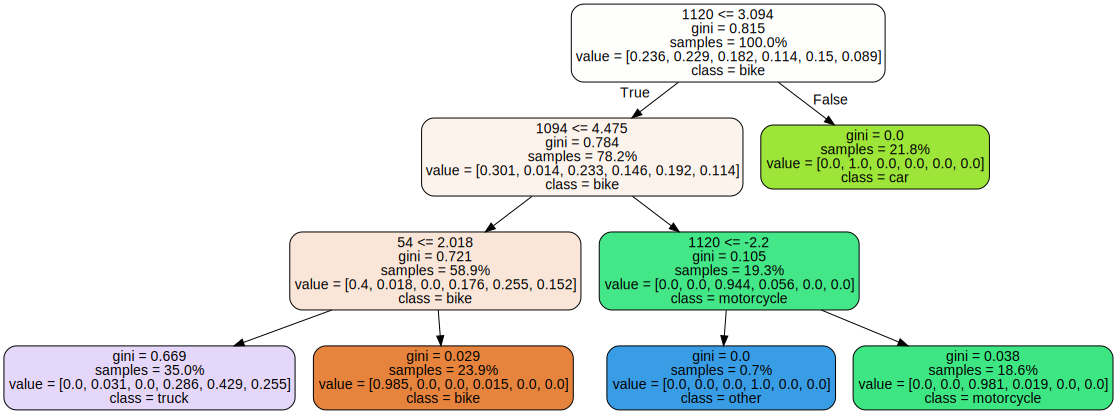

In [10]:
# visualize the new decision tree
dot_data2 = export_graphviz(dt2, # tree to export
                            out_file = None, feature_names =
                            # top 7 highest variance features: 54, 1094, 1120,  183, 1022,  279,  148
                            dt_pca_df.sort_values(by = "variance", ascending = False).index[:7].values,
                            class_names = ["bike", "car", "motorcycle", "other", "truck", "van"], 
                            proportion = True, filled = True, rounded = True)

graphviz.Source(dot_data2)

The algorithm decides that feature 1120 is the most important feature here and that it should constitute the first node. Feature 1094 is taken into accound in the second level.

In general, I'd argue that simple decision trees are not able to successfully classify images based on linked decision rules. If we'd increase the depth, accuracy might go up, but the model would almost certainly overfit and not be able to generalize from the learned rules. Let's test that quickly.

In [11]:
# create decision tree without depth limit
dt3 = DecisionTreeClassifier(criterion = "gini", max_depth = None, random_state = 0)

# fit non-PCA data
dt3.fit(hl_tr_features, tr_labels)

# get validation accuracy
dt3_accuracy = dt3.score(hl_val_features, val_labels)

print("validation accuracy, no depth limit:", dt3_accuracy)
print("train accuracy, no depth limit:", dt3.score(hl_tr_features, tr_labels))
print("test accuracy, no depth limit:", dt3.score(hl_te_features, te_labels))

validation accuracy, no depth limit: 0.7338129496402878
train accuracy, no depth limit: 1.0
test accuracy, no depth limit: 0.76


In [12]:
# get depth of max_depth decision tree
dt3.tree_.max_depth

11

With a depth of 11, we can reach a train accuracy of 100%, i.e. enough rules have been created that we can classify each data point correctly. 

However, while we can reach 100% train accuracy, the validation and test set accuracy is limited to 73%-76%. This is still around 10 percentage points better than depth = 3, but the model is widely overfitting. In this case, we have a model with **low (--> 0) bias but extremely high variance**. 

In [13]:
# create a DataFrame to store our the test accuracies and save the file
save_df = pd.DataFrame({
    "model": ["decision tree"],
    "test_accuracy": [dt2_accuracy]
})

# save the df
save_df.to_csv("/Users/Ingo/Python Files/Course-project4/03_decision-tree-results.csv",
              index = False)